In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import AR, ARIMA, ARMA

df = pd.read_csv('./datasets/train.csv')
df.set_index('Date', inplace=True)  #want to set the index to the date so every row is a different date
df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [235]:
df.shape  #woah. 

(421570, 4)

In [236]:
#filter to only include store 1

store1 = df[df.Store == 1]
# there are about 45 different stores in this dataset.
store1.head() 

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [237]:
store1.shape

(10244, 4)

In [238]:
store1.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [251]:
# #compute total weekly sales for store 1

store1_sales = pd.DataFrame(store1['Weekly_Sales'].groupby(store1.index).sum())

store1_sales.head()

# # Grouped weekly sales by store 1

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [252]:
# Update index to datetime type
store1_sales.index = pd.to_datetime(store1_sales.Weekly_Sales.index)

# Check index type to verify series type is expected
store1_sales.index.dtype

dtype('<M8[ns]')

In [253]:
# Check dataframe for expected data
store1_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


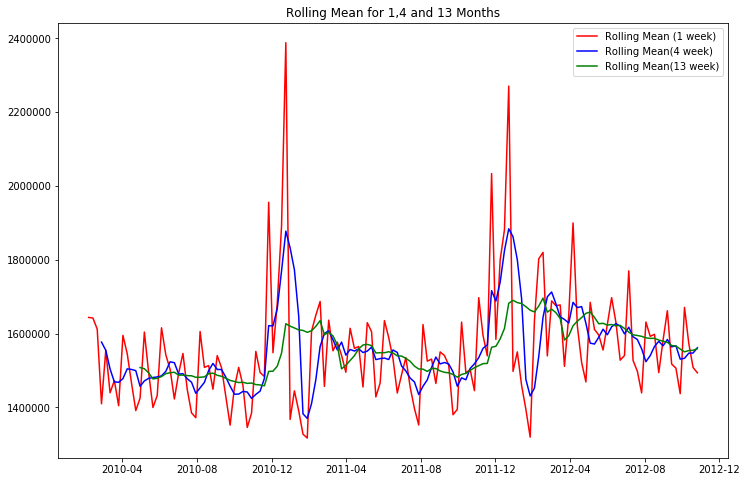

In [254]:
rolmean1  = store1_sales.rolling(window = 1).mean()   #looking to see how trends might differ depending on how big our window of time is
rolmean4  = store1_sales.rolling(window = 4).mean()
rolmean13 = store1_sales.rolling(window = 13).mean()

fig = plt.figure(figsize=(12, 8))
mean = plt.plot(rolmean1, color='red', label='Rolling Mean (1 week)')
mean = plt.plot(rolmean4, color='blue', label='Rolling Mean(4 week)')
mean = plt.plot(rolmean13, color='green', label='Rolling Mean(13 week)')

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Months')
plt.show()

In [255]:
print('1 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=1))
print('2 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=2))
print('52 Week Lag AutoCorr', store1_sales['Weekly_Sales'].autocorr(lag=52))

1 Week Lag AutoCorr 0.302158279411
2 Week Lag AutoCorr 0.127413130554
52 Week Lag AutoCorr 0.895376029478


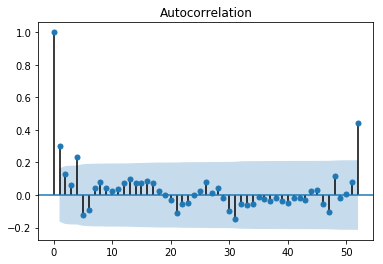

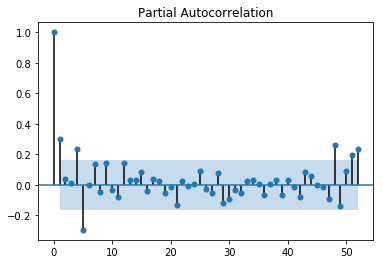

In [256]:
# 52 week Autocorr and Partial Autocorr
plot_acf(store1_sales, lags =52)
plot_pacf(store1_sales, lags =52)

plt.show()

"Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)

In [257]:
store1_sales['Weekly_Sales_diff'] = store1_sales['Weekly_Sales'].diff(periods =1)

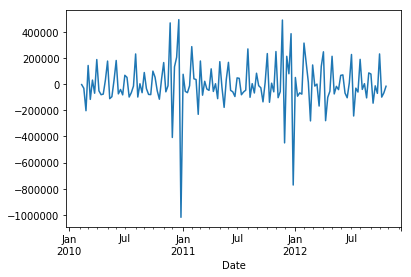

In [258]:
store1_sales['Weekly_Sales_diff'].plot()

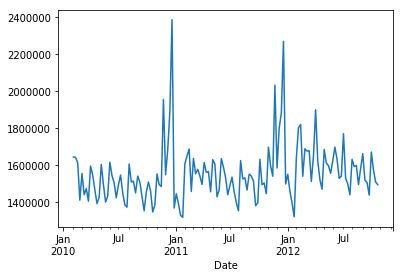

In [259]:
store1_sales['Weekly_Sales'].plot()

In [261]:
store1_sales.head()

,Weekly_Sales,Weekly_Sales_diff
Date,,
2010-02-05,1643690.90,NaN
2010-02-12,1641957.44,-1733.46
2010-02-19,1611968.17,-29989.27
2010-02-26,1409727.59,-202240.58
2010-03-05,1554806.68,145079.09


Split the weekly sales data in a training and test set - using the first 75% of the data for training.

In [262]:
store1_sales.shape

(143, 2)

In [265]:
#shape of information is 143 rows.  
143*0.75
# let's use the first 107 rows for training, next 36 rows for testing

107.25

In [266]:
train = store1_sales.head(107)
test = store1_sales.tail(36)

Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [162]:
#let's compare weekly_sales vs weekly_sales_diff when modeling. we'll start with weekly_sales

In [163]:
# train_dates = train.index

AR1 = ARMA(train.Weekly_Sales, (1,0)).fit()  

In [190]:
# For reference
test_dates = test.index
test_values = test.Weekly_Sales.values

# The AR Predict takes a start and and end date as values and not a list.
start = test.index[0]
end = test.index[-1]

AR1_pred = AR1.predict(start=start, end=end)

In [269]:
test_values[:5], AR1_pred[:5]

(array([ 1539387.83,  1688420.76,  1675431.16,  1677472.78,  1511068.07]),
 2012-02-24    1.630649e+06
 2012-03-02    1.571107e+06
 2012-03-09    1.552370e+06
 2012-03-16    1.546475e+06
 2012-03-23    1.544619e+06
 Freq: W-FRI, dtype: float64)

In [270]:
from sklearn.metrics import mean_absolute_error, r2_score
mean_absolute_error(test_values, AR1_pred)

81839.33863162389

In [273]:
r2_score(test_values, AR1_pred)

-0.22426249369042739

In [200]:
#So here we're off by about $81-82,000 a week in sales. considering our range is 1.4m - 1.7m, thats about a 6 percent error.

In [274]:
#going to plot the residuals for this model:

AR1_residuals = (test_values) - (AR1_pred)


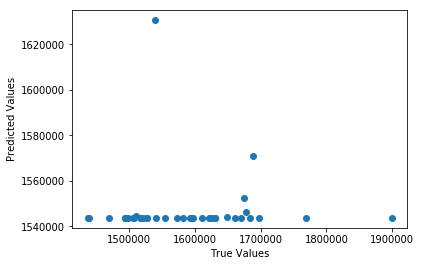

In [275]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, AR1_pred)
plt.show()

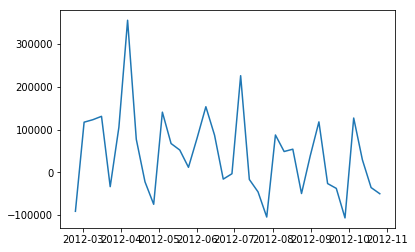

In [203]:
plt.plot(AR1_residuals)
plt.show()

In [204]:
#now let's try this same thing with the weekly_sales_diff... this becomes more complicated because we end up with a Nan in the first row in our training set

In [277]:
train_dates = train.index
train_dates

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2011-12-16', '2011-12-23', '2011-12-30', '2012-01-06',
               '2012-01-13', '2012-01-20', '2012-01-27', '2012-02-03',
               '2012-02-10', '2012-02-17'],
              dtype='datetime64[ns]', name='Date', length=107, freq=None)

In [278]:
train_diff = train.tail(106)

In [279]:
train_diff.head()

,Weekly_Sales,Weekly_Sales_diff
Date,,
2010-02-12,1641957.44,-1733.46
2010-02-19,1611968.17,-29989.27
2010-02-26,1409727.59,-202240.58
2010-03-05,1554806.68,145079.09
2010-03-12,1439541.59,-115265.09


In [208]:
AR1_diff = ARMA(train_diff.Weekly_Sales_diff, (1,0)).fit()  

In [282]:
# For reference
test_dates = test.index
test_values_diff = test.Weekly_Sales_diff.values  #we don't need to modify the test set because there isn't a null there

# The AR Predict takes a start and and end date as values and not a list.
start = test.index[0]
end = test.index[-1]

AR1_diff_pred = AR1_diff.predict(start=start, end=end)

In [283]:
mean_absolute_error(test_values_diff, AR1_diff_pred)

105712.46084446814

In [284]:
#we actually get a larger error when looking at the difference between dates rather than the raw values...
#curiouser and curiouser... 

In [285]:
#for weekly sales diff:
AR1_diff_residuals = test_values_diff - AR1_diff_pred


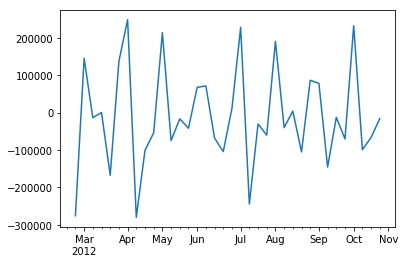

In [286]:
AR1_diff_residuals.plot()

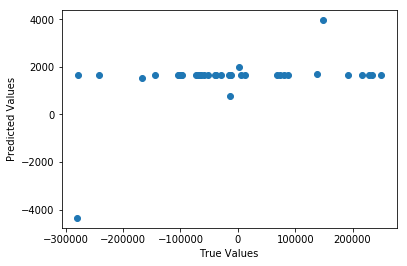

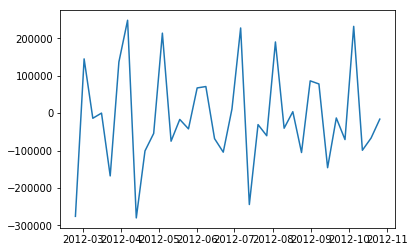

In [287]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values_diff, AR1_diff_pred)
plt.show()

plt.plot(AR1_diff_residuals)
plt.show()

Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

In [289]:
# For weekly Sales:

AR2 = ARMA(train.Weekly_Sales, order = (2,0)).fit()

# Same start and end we outlined earlier.
AR2_pred = AR2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_pred)

81203.239532436957

In [291]:
#weekly sales diff
AR2_diff = ARMA(train_diff.Weekly_Sales_diff, order = (2, 0)).fit()

AR2_diff_pred = AR2_diff.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_diff_pred)

1588544.4943707457

In [292]:
#weekly sales

AR2_2 = ARMA(train.Weekly_Sales, order = (2,2)).fit()

# Same start and end we outlined earlier.
AR2_2_pred = AR2_2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_2_pred)

80503.356394581293

In [233]:
# weekly_sales diff

AR2_2diff = ARMA(train_diff.Weekly_Sales_diff, order = (1, 1)).fit()

AR2_2diff_pred = AR2_2diff.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_2diff_pred)

/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed,

1594129.4415546118